In [1]:
library(CausalImpact)
library(matrixStats)
library(dtw)
library(forecast)
library(Hmisc)

Loading required package: bsts
Loading required package: BoomSpikeSlab
Loading required package: Boom
Loading required package: MASS

Attaching package: ‘Boom’

The following object is masked from ‘package:stats’:

    rWishart

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: xts
Loading required package: proxy

Attaching package: ‘proxy’

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix

Loaded dtw v1.18-1. See ?dtw for help, citation("dtw") for use in publication.

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units



In [2]:
data <- read.csv(file = 'CausalImpact_homework_data1.csv', header = TRUE, sep = ',')

In [3]:
head(data)

date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
2013-12-18,21110.60,5855898,10490066,6400020,17303909,8277376,202418.0,501304.0,281527.7,⋯,2.46,20.30,11.76,13.53,27.36,23.53,41.25,NA,23.73,9.24
2013-12-19,19985.20,5233946,8856544,5772768,13711773,7417712,195205.4,456269.5,222715.5,⋯,2.05,13.05,12.25,14.76,28.50,28.96,37.95,11.94,31.64,6.93
2013-12-20,19602.36,4923801,8346250,5429014,12574661,6999351,205468.9,496172.0,283458.8,⋯,1.23,23.20,10.78,9.84,45.03,27.15,34.65,7.96,28.25,3.85
2013-12-21,21955.16,6061035,10408902,6624329,17318726,8561364,210051.0,516636.4,272849.0,⋯,3.28,24.65,10.78,11.07,44.46,25.34,36.30,5.97,38.42,8.47
2013-12-22,22388.32,6139137,10323537,6646342,16883212,8662216,217223.1,530008.4,269956.1,⋯,1.23,31.90,12.74,11.07,53.01,23.53,49.50,3.98,39.55,5.39
2013-12-23,23793.20,6368549,10494566,6864796,17262817,8962794,209871.1,536184.1,308934.5,⋯,1.64,26.10,6.86,8.61,51.87,18.10,46.20,3.98,35.03,12.32


In [4]:
intervention <- read.csv(file = 'CausalImpact_homework_data2.csv', header = TRUE, sep = ',')

In [5]:
head(intervention)

num,start_date,end_date,estimation_size_of_marketing_activity,is_related_to_our_service
1,26,56,4.6,1
2,31,60,0.1,0
3,52,66,0.5,1
4,111,144,5.7,1
5,174,197,2.6,0
6,200,212,10.0,0


Видим в intervention много нерелевантных по времени кампаний. Чтобы их отсеять, найдем, какие номера соответствуют началу и концу анализируемого периода:

In [6]:
num_start <- which(as.Date(data$date) >= as.Date("2015-08-01"))[1]
num_end <- which(as.Date(data$date) >= as.Date("2015-12-01"))[1] - 1

In [7]:
intervention <- intervention[intervention$end_date >= num_start & intervention$start_date <= num_end, ]

Посмотрим, что осталось в intervention:

In [8]:
intervention

,num,start_date,end_date,estimation_size_of_marketing_activity,is_related_to_our_service
22,22,560,599,4.9,0
25,25,623,637,1.5,1
26,26,623,668,0.1,1
27,27,630,668,0.0,0
28,28,633,644,0.7,0
29,29,651,667,0.4,0
30,30,690,720,0.2,1
31,31,694,707,0.0,1
32,32,697,730,0.1,0
33,33,708,725,1.5,1


Первая кампания не нужна, так как она не относится к нашему сервису и не влият на относящиеся кампании, потому что не пересекается с ними по времени. Уберем ее:

In [9]:
intervention <- intervention[2:nrow(intervention), ]

В data данные после окончания последней кампании ноября 2015 нам тоже не нужны. До августа 2015 нужны, так как на них будем обучаться:

In [10]:
data <- data[1:730, ]

Итак, видно, что первая интересующая нас кампания начинается на 623-й день. С этого же периода можно будет считать, что target оказался подверженным воздействию и пытаться оценивать эффективности кампаний. Посмотрим, что это за дата:

In [11]:
data[623, ]

,date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
623,2015-09-01,402400.9,18744564,27471358,14500756,52415833,26232159,995043.3,1794159,314299.4,⋯,94.3,1023.7,745.78,143.91,1263.69,331.23,4499.55,224.87,1589.91,171.71


В качестве времени, когда target не был подвержен кампаниям, относящимся к нашему сервису, таким образом можно считать дни от 456 до 622 включительно (455 -- последний день кампаний, которые is_related_to_our_service, до 623 дня). Именно этот период мы будем рассматривать при выборе ряда-предиктора, когда нам нужно будет понять, что предиктор может прогнозировать таргет в условиях, когда кампании, относящиеся к сервису, не проводятся.

In [12]:
data[456, ]

,date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
456,2015-03-18,271340.4,13596933,19966044,10680066,43155813,19059119,865486.1,1433803,301570.4,⋯,21.32,574.2,378.28,51.66,387.6,133.94,651.75,67.66,857.67,84.7


Давайте тогда оставим данные от 18 марта до 30 ноября 2015:

In [13]:
data <- data[456:nrow(data), ]

In [14]:
head(data)

,date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
456,2015-03-18,271340.4,13596933,19966044,10680066,43155813,19059119,865486.1,1433803,301570.4,⋯,21.32,574.20,378.28,51.66,387.60,133.94,651.75,67.66,857.67,84.70
457,2015-03-19,267945.2,13250533,19590436,10453814,43211262,18583910,879163.2,1437657,281317.0,⋯,24.60,636.55,425.32,67.65,481.08,190.05,732.60,79.60,937.90,80.08
458,2015-03-20,261622.5,12288823,18556680,9747972,43266712,17266068,838302.0,1362299,264518.3,⋯,24.19,597.40,420.42,59.04,479.94,228.06,765.60,81.59,1066.72,77.77
459,2015-03-21,289697.0,15666805,22335362,12152473,43322161,21895386,928537.7,1531178,311173.2,⋯,36.08,713.40,425.81,77.49,489.06,231.68,742.50,71.64,1157.12,89.32
460,2015-03-22,264950.4,14549435,21824108,11482922,43377610,20328812,938637.1,1553960,309376.3,⋯,25.83,771.40,450.80,62.73,498.75,257.02,768.90,99.50,1203.45,95.48
461,2015-03-23,277191.8,14870556,21910612,11725615,43433059,20802817,950107.1,1577942,308639.5,⋯,24.60,653.95,461.58,78.72,493.05,179.19,730.95,67.66,1058.81,88.55


Посмотрим теперь, как выглядит target:

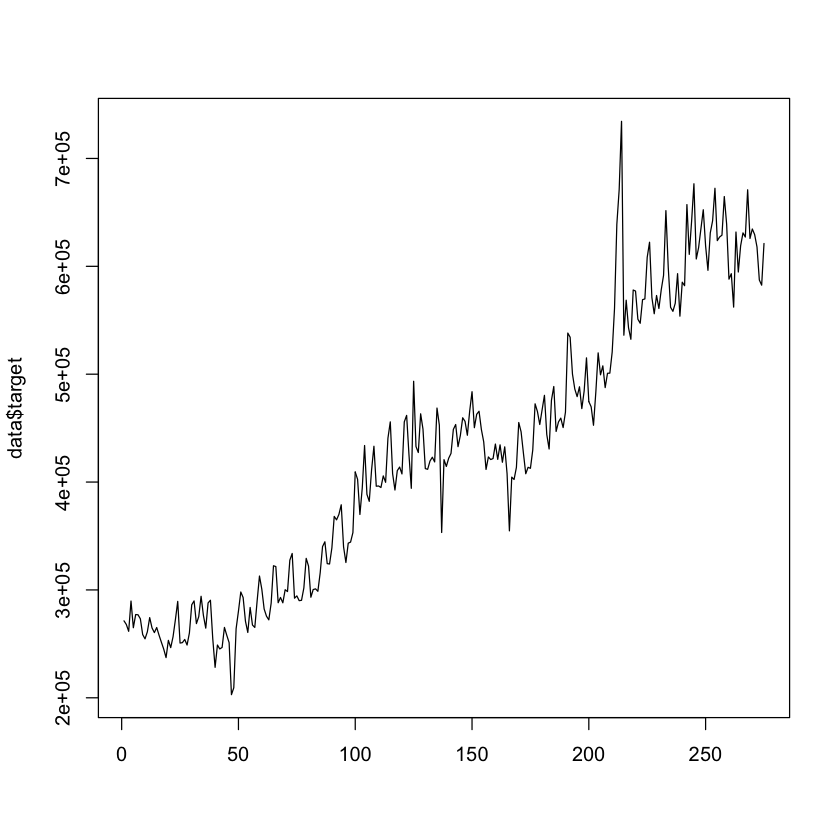

In [15]:
matplot(data$target, type = "l")

Точки 137, 166 и 214 выглядят как выбросы, избавимся от них:

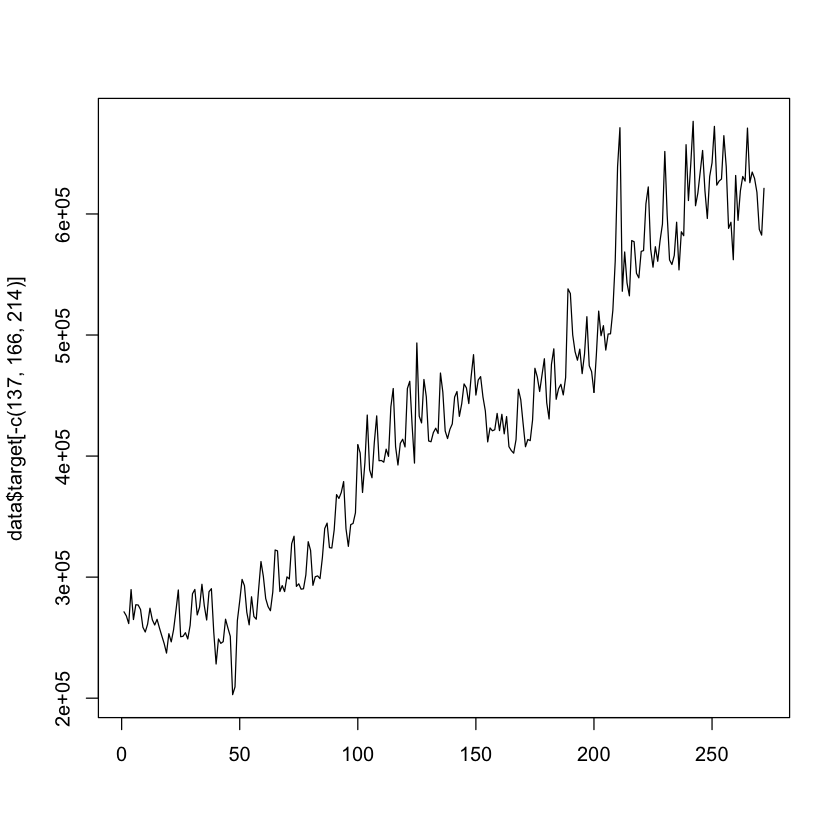

In [16]:
matplot(data$target[-c(137, 166, 214)], type = "l")

Стало получше. Удаляем из данных:

In [17]:
data <- data[-c(137, 166, 214), ]

Теперь уже можно начать искать ряды-предикторы.

Чтобы было удобно сравнивать похожесть рядов, давайте их отмасштабируем (как было указано где-то в предыдущих пунктах дз, Causal Impact устойчив относительно линейных преобразований). Для этого еще удалим все N/A. Благо, таких строк в нужных данных, меньше 2%:

In [18]:
sum(complete.cases(data)) / nrow(data)

[1] 0.9816176

In [19]:
data <- data[complete.cases(data), ]

Отнимаем минимумы по колонкам:

In [20]:
data_wo_date <- data[2:ncol(data)]
col_mins <- colMins(as.matrix(data_wo_date))
data[2:ncol(data)] <- data_wo_date - matrix(col_mins, nrow = nrow(data), ncol = ncol(data) - 1, byrow = TRUE)

Делим на максимумы:

In [21]:
data_wo_date <- data[2:ncol(data)]
col_maxs <- colMaxs(as.matrix(data_wo_date))
data[2:ncol(data)] <- data_wo_date / matrix(col_maxs, nrow = nrow(data), ncol = ncol(data) - 1, byrow = TRUE)

In [22]:
head(data)

,date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
456,2015-03-18,0.1445033,0.2670687,0.3087740,0.5482244,0.000000000,0.2695070,0.1539666,0.10795364,0.1748870,⋯,0.01168969,0.03913043,0.05399196,0.02068966,0.00000000,0.009195402,0.00284540,0.03225806,0.00000000,0.05992509
457,2015-03-19,0.1373347,0.2466993,0.2884791,0.5329958,0.003649635,0.2491679,0.1733243,0.11039326,0.1391911,⋯,0.02019129,0.10144928,0.10913268,0.11034483,0.06133134,0.080459770,0.01833702,0.05645161,0.03056393,0.03745318
458,2015-03-20,0.1239851,0.1901479,0.2326231,0.4854867,0.007299270,0.1927637,0.1154919,0.06268969,0.1095839,⋯,0.01912859,0.06231884,0.10338886,0.06206897,0.06058340,0.128735632,0.02466013,0.06048387,0.07963840,0.02621723
459,2015-03-21,0.1832612,0.3887834,0.4367934,0.6473298,0.010948905,0.3909004,0.2432059,0.16959442,0.1918116,⋯,0.04994687,0.17826087,0.10970706,0.16551724,0.06656694,0.133333333,0.02023396,0.04032258,0.11407663,0.08239700
460,2015-03-22,0.1310116,0.3230787,0.4091693,0.6022634,0.014598540,0.3238504,0.2575000,0.18401594,0.1886445,⋯,0.02337938,0.23623188,0.13900057,0.08275862,0.07292446,0.165517241,0.02529244,0.09677419,0.13172622,0.11235955
461,2015-03-23,0.1568579,0.3419616,0.4138432,0.6185987,0.018248175,0.3441380,0.2737339,0.19919712,0.1873460,⋯,0.02019129,0.11884058,0.15163699,0.17241379,0.06918474,0.066666667,0.01802087,0.03225806,0.07662505,0.07865169


Получили во всех колонках значения от 0 до 1.

Теперь такие ряды можно сравнить по корреляциям фич с таргетом и визуально и выбрать подходящий predictor. Сравнивать будем весь период с 18 марта до 31 августа, но потом еще проверим, что зависимость с сентября по конец ноября между предиктором и таргетом меняется не сильно.

In [23]:
data[c(1, 162), ]

,date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
456,2015-03-18,0.1445033,0.2670687,0.3087740,0.5482244,0.0000000,0.2695070,0.1539666,0.1079536,0.1748870,⋯,0.01168969,0.03913043,0.05399196,0.02068966,0.0000000,0.009195402,0.0028454,0.03225806,0.000000,0.05992509
622,2015-08-31,0.4257814,0.5753720,0.7456849,0.8171882,0.6058394,0.5818818,0.3815882,0.3659130,0.1911297,⋯,0.20828905,0.46666667,0.51694428,0.44827586,0.6148093,0.356321839,0.7922858,0.40725806,0.329746,0.40449438


In [24]:
cor(data[1:162, c(2, 43:53)])

,target,may_be_not_impacted_2,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
target,1.0000000,0.3536918,0.2092735,0.5256099,0.5741809,0.3568101,0.8494164,0.3399285,0.7392785,0.2666050,0.5478849,0.4287555
may_be_not_impacted_2,0.3536918,1.0000000,0.3917204,0.6115175,0.7845759,0.7219184,0.6822278,0.3439857,0.7868107,0.8085469,0.2909526,0.9271725
may_be_not_impacted_3,0.2092735,0.3917204,1.0000000,0.4478142,0.1287202,0.6103848,0.4165566,0.9213287,0.4961700,0.7491816,0.6144484,0.2840621
may_be_not_impacted_4,0.5256099,0.6115175,0.4478142,1.0000000,0.6896173,0.8702688,0.6951739,0.5819326,0.6539136,0.7420778,0.7512481,0.6803148
may_be_not_impacted_5,0.5741809,0.7845759,0.1287202,0.6896173,1.0000000,0.6201800,0.6986803,0.1561157,0.6579097,0.5380099,0.2657201,0.9153466
may_be_not_impacted_6,0.3568101,0.7219184,0.6103848,0.8702688,0.6201800,1.0000000,0.6354179,0.6630981,0.6738974,0.8795974,0.6753165,0.7224769
may_be_not_impacted_7,0.8494164,0.6822278,0.4165566,0.6951739,0.6986803,0.6354179,1.0000000,0.5024699,0.9680553,0.6098098,0.6345942,0.6809384
may_be_not_impacted_8,0.3399285,0.3439857,0.9213287,0.5819326,0.1561157,0.6630981,0.5024699,1.0000000,0.5388390,0.7238853,0.8231775,0.2724323
may_be_not_impacted_9,0.7392785,0.7868107,0.4961700,0.6539136,0.6579097,0.6738974,0.9680553,0.5388390,1.0000000,0.7188655,0.5940688,0.7226314
may_be_not_impacted_10,0.2666050,0.8085469,0.7491816,0.7420778,0.5380099,0.8795974,0.6098098,0.7238853,0.7188655,1.0000000,0.5880037,0.7259143


Итак, оставим в качестве кандидатов следующие may_be_not_impacted: 4, 5, 7, 9, 11. Дальше Causal Impact разберется сам, а мы посмотрим потом, что он выбрал с помощью plot(impact\$model\$bsts.model, "coefficients") -- posterior probability of each predictor being included in the model (если получится).

И не забудем посмотреть, как эти предикторы выглядят, да:

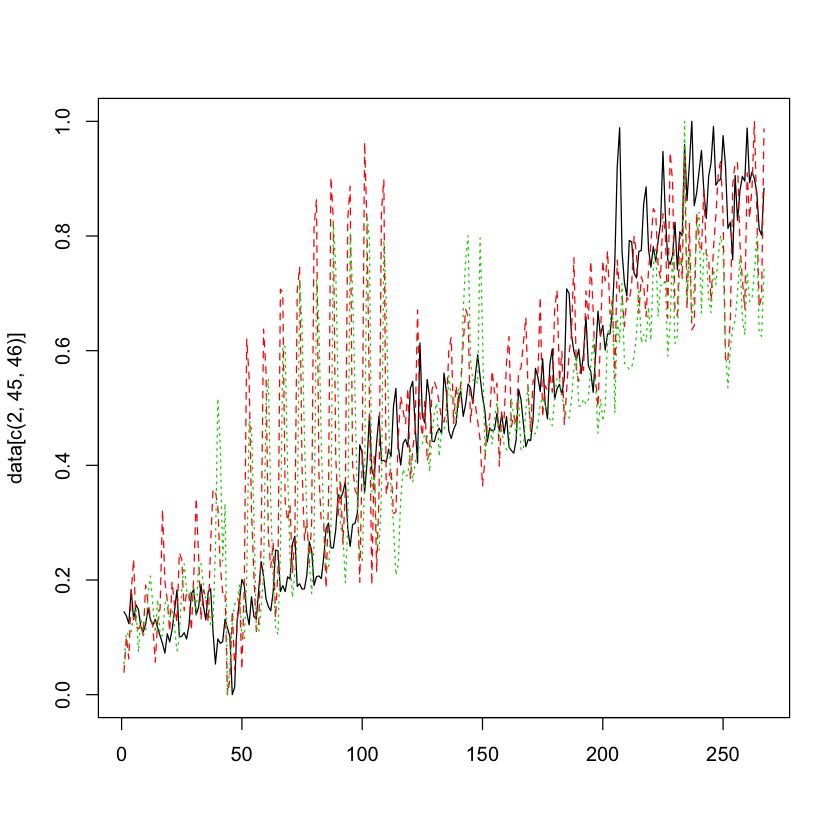

In [25]:
matplot(data[c(2, 45, 46)], type = "l")

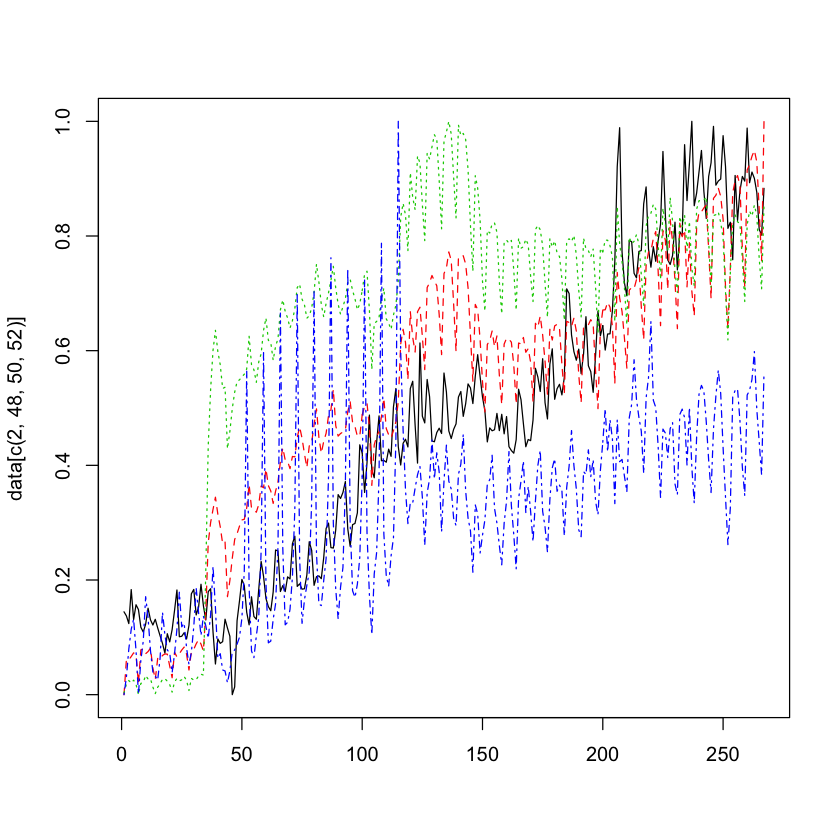

In [26]:
matplot(data[c(2, 48, 50, 52)], type = "l")

В целом, совсем уж странных вещей и смен зависимостей после 164 дня не наблюдается, так что продолжим.

Warning message:
“Removed 267 rows containing missing values (geom_path).”Warning message:
“Removed 105 rows containing missing values (geom_path).”Warning message:
“Removed 534 rows containing missing values (geom_path).”

Posterior inference {CausalImpact}

                         Average           Cumulative     
Actual                   0.49              15.72          
Prediction (s.d.)        0.49 (0.025)      15.60 (0.800)  
95% CI                   [0.45, 0.53]      [14.53, 17.11] 
                                                          
Absolute effect (s.d.)   0.0037 (0.025)    0.1180 (0.800) 
95% CI                   [-0.044, 0.037]   [-1.397, 1.184]
                                                          
Relative effect (s.d.)   0.76% (5.1%)      0.76% (5.1%)   
95% CI                   [-9%, 7.6%]       [-9%, 7.6%]    

Posterior tail-area probability p:   0.44444
Posterior prob. of a causal effect:  56%

For more details, type: summary(impact, "report")



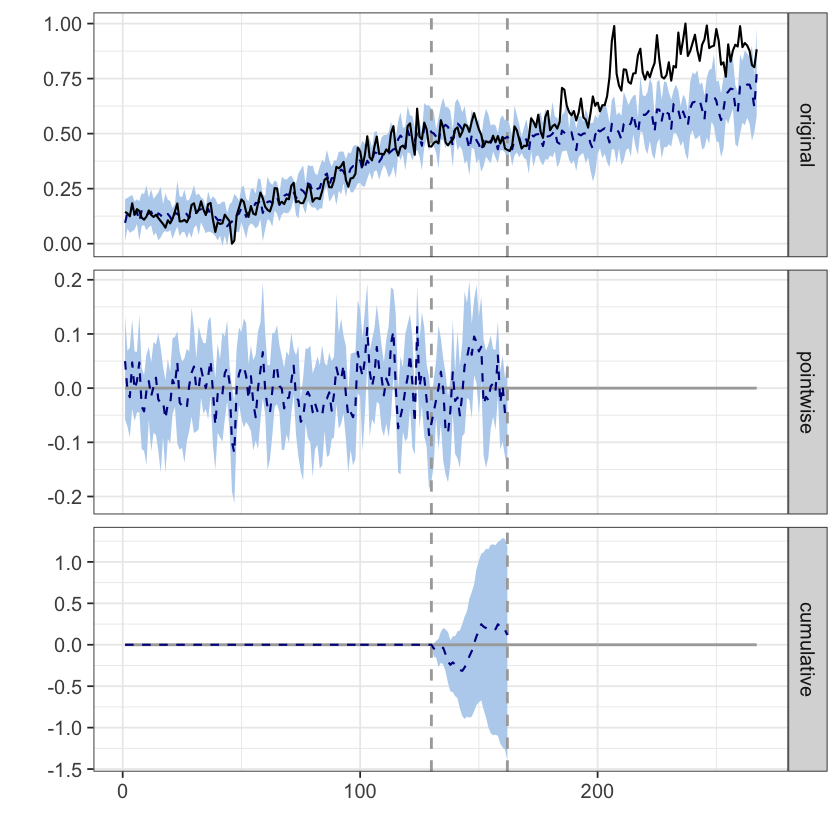

In [27]:
pre.period <- c(1, 130)
post.period <- c(131, 162)

set.seed(0)
test.data <- cbind(data$target, data$may_be_not_impacted_4, data$may_be_not_impacted_5, data$may_be_not_impacted_7,
                   data$may_be_not_impacted_9, data$may_be_not_impacted_11)
impact <- CausalImpact(test.data, pre.period, post.period)
plot(impact)
summary(impact)

Видим, что ошибка в пределах 0.1 (но помним, что и сами данные мы отмасштабировали), absolute effect равен 0.0037, а доверительный интервал для него не очень широкий и включает ноль, так что делаем вывод, что предиктором можно пользоваться.

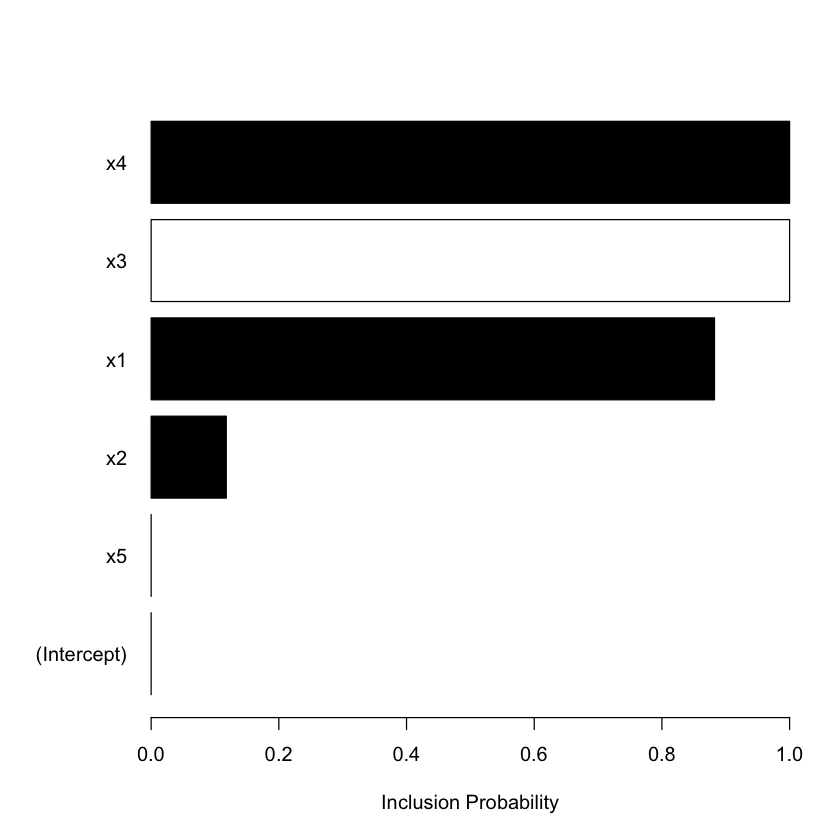

In [28]:
plot(impact$model$bsts.model, "coefficients")

Посмотрели на posterior probability of each predictor being included in the model. 4 и 3 это ряды may_be_not_impacted 9 и 7 соответственно. Ну да, у них была наибольшая корреляция, порадуемся.

Предскажем теперь общий эффект от всех кампаний, а потом, в зависимости от дат и estimation_size_of_marketing_activity, будем решать, насколько та или иная кампания была эффективна.

In [29]:
data[c(163, nrow(data)), ]

,date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
623,2015-09-01,0.4212229,0.5697650,0.7143024,0.8053890,0.6094891,0.5765162,0.3373337,0.3360686,0.1973214,⋯,0.2008502,0.4884058,0.4847789,0.5379310,0.5747943,0.2597701,0.7401201,0.3508065,0.2789496,0.4831461
730,2015-12-17,0.8831060,0.5722289,0.7470528,0.8104449,1.0000000,0.5992364,0.8656757,0.9501144,0.8794588,⋯,0.2688629,0.9869565,0.7421022,0.8482759,1.0000000,0.5218391,0.8545684,0.5241935,0.5617736,0.8464419


Warning message:
“Removed 267 rows containing missing values (geom_path).”Warning message:
“Removed 534 rows containing missing values (geom_path).”

Posterior inference {CausalImpact}

                         Average        Cumulative    
Actual                   0.73           77.03         
Prediction (s.d.)        0.56 (0.04)    58.36 (4.17)  
95% CI                   [0.47, 0.63]   [49.76, 66.56]
                                                      
Absolute effect (s.d.)   0.18 (0.04)    18.67 (4.17)  
95% CI                   [0.1, 0.26]    [10.5, 27.27] 
                                                      
Relative effect (s.d.)   32% (7.1%)     32% (7.1%)    
95% CI                   [18%, 47%]     [18%, 47%]    

Posterior tail-area probability p:   0.00379
Posterior prob. of a causal effect:  99.62121%

For more details, type: summary(impact, "report")



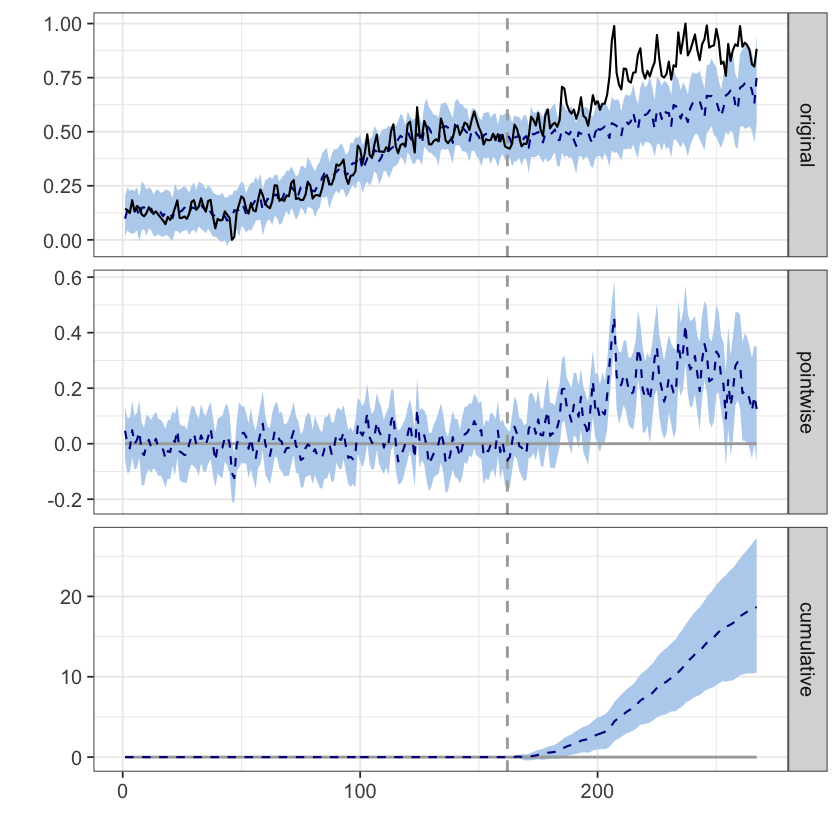

In [30]:
pre.period <- c(1, 162)
post.period <- c(163, nrow(data))

set.seed(0)
test.data <- cbind(data$target, data$may_be_not_impacted_4, data$may_be_not_impacted_5, data$may_be_not_impacted_7,
                   data$may_be_not_impacted_9, data$may_be_not_impacted_11)
impact <- CausalImpact(test.data, pre.period, post.period)
plot(impact)
summary(impact)

In [31]:
result <- impact$series

Вспомним теперь про intervention. Кроме того, что есть в табличке, есть еще кампания, которая могла влиять на рассматриваемый период: 36,718,725,1.7,1. Мы ее анализировать не будем, но рассматриваем период до 725 дня, так что в impactе она есть и учитывать это надо.

In [32]:
intervention

,num,start_date,end_date,estimation_size_of_marketing_activity,is_related_to_our_service
25,25,623,637,1.5,1
26,26,623,668,0.1,1
27,27,630,668,0.0,0
28,28,633,644,0.7,0
29,29,651,667,0.4,0
30,30,690,720,0.2,1
31,31,694,707,0.0,1
32,32,697,730,0.1,0
33,33,708,725,1.5,1
34,34,708,725,0.7,1


Итого, нам надо оценить 25, 26, 30, 31, 33-35. Последние три по дням совпадают, так что будем считать их одной кампанией, а потом получившуюся эффективность поделим пропорционально estimation_size_of_marketing_activity.

Логика, которой я руководствуюсь при определении эффекта, была описана в письме с вопросами, следующая вставка оттуда:

Что значит "оценить эффективности рекламных кампаний"? Ранее мы рассуждали об этом только в бинарном виде: повлияла кампания или нет. Предполагаю, что это относительная разница между тем, какие значения могли бы быть у таргета и какие они на самом деле. То есть если у меня таргет мог бы без кампаний быть 10-20-25, а получился 15-25-35, то ответ будет таким: ((15 - 10) / 10 + (25 - 20) / 25 + (35 - 25) / 25) / 3.

Поскольку разница относительная, то нам не важно, что таргет был отмасштабирован.

In [56]:
gain <- 100 * (data$target - result$point.pred) / result$point.pred

Получили относительный прирост аудитории для каждого дня в процентах (но это для всех дней, мы будем смотреть только с 163, то есть 1 сентября). Между кампаниями 26 и 30, конечно, был перерыв в рекламе, а прирост активности все равно есть, но не имея данных о природе кампаний нельзя как-то по-умному воспользоваться этими данными, поэтому про них забудем.

Смотрим на кампанию 25: она пересекается с 26, 27, 28. Учтем это.

In [64]:
data[c(163,170,173,176), ]

,date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
623,2015-09-01,0.4212229,0.5697650,0.7143024,0.8053890,0.6094891,0.5765162,0.3373337,0.3360686,0.1973214,⋯,0.2008502,0.4884058,0.4847789,0.5379310,0.5747943,0.2597701,0.7401201,0.3508065,0.2789496,0.4831461
630,2015-09-08,0.4430577,0.5508278,0.7788244,0.8218814,0.6350365,0.5594563,0.2802877,0.2999663,0.1886497,⋯,0.1838470,0.4594203,0.4508903,0.3862069,0.5796559,0.2712644,0.7303193,0.3346774,0.3198450,0.3745318
633,2015-09-11,0.5541785,0.4766649,0.6192186,0.7235355,0.6459854,0.4910268,0.5131782,0.4626345,0.2218575,⋯,0.2646121,0.5550725,0.4704193,0.5034483,0.6409873,0.4390805,0.8185267,0.4112903,0.3994834,0.3483146
637,2015-09-15,0.5091163,0.6537201,0.9033690,0.8764866,0.6605839,0.6639973,0.4362397,0.4474633,0.2928097,⋯,0.2104145,0.5391304,0.5043079,0.4551724,0.5811518,0.2620690,0.7176731,0.3467742,0.2922944,0.4419476


In [65]:
1.5 * (  sum(gain[163:169]) / (1.5 + 0.1)
       + sum(gain[170:172]) / (1.5 + 0.1)
       + sum(gain[173:176]) / (1.5 + 0.1 + 0.7)) / (176 - 163)

[1] 3.751729

Это оценка эффективности для кампании 25. Теперь по такому же принципу оценим 26, 30, 31, 33-35.

26:

In [69]:
data[c(183,190,206,207), ]

,date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
644,2015-09-22,0.5228233,0.5535235,0.8434532,0.8103221,0.6861314,0.5676091,0.4503557,0.4769938,0.3228501,⋯,0.2316684,0.5985507,0.5192418,0.5034483,0.5759162,0.2666667,0.7252608,0.3911290,0.3564356,0.5318352
651,2015-09-29,0.6026693,0.5951960,0.9754646,0.8160593,0.7116788,0.6109791,0.5306271,0.5519148,0.3479470,⋯,0.2348565,0.5463768,0.5037335,0.4758621,0.5579656,0.2827586,0.7056592,0.3870968,0.2875592,0.4232210
667,2015-10-15,0.9209968,0.9075402,0.9495212,1.0000000,0.7700730,0.9295795,0.6554835,0.6448559,0.4409058,⋯,0.2529224,0.7579710,0.6570936,0.5172414,0.7363500,0.4482759,0.8514069,0.5403226,0.4791218,0.5355805
668,2015-10-16,0.9888558,0.8794679,0.8328968,0.9194912,0.7737226,0.9032850,0.6554835,0.6448559,0.4409058,⋯,0.2709883,0.7014493,0.6140149,0.5379310,0.6922214,0.4160920,0.7865950,0.3870968,0.4063711,0.4194757


Я немножко не успеваю до дедлайна, но в целом для остальных кампаний сделаю так же и отправлю.